
![X Education Logo](./Logos/X_education.png) 
# <span style="color:Green"> X Education- Online Courses: Lead Score Case Study  </span>

##### Business question
`X Education` is an EduTech company which sells online course materials to industry professionals on their website. When someone visits their website and registers with email and phone number, the company classifies them as a *LEAD*. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is aroun **30%**. 

To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’. If they successfully identify this set of leads, the lead conversion rate should go up as the sales team will now be focusing more on communicating with the potential leads rather than making calls to everyone.

➡️ The company requires us (`Rohit and Rakesh`) to build a model wherein we need to assign a **lead score** to each of the leads such that the customers with a higher lead score have a higher conversion chance and the customers with a lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be aroun **80%**.

### <span style="color:blue"> Data Understanding, Preparation & EDA  </span>

In [838]:
# Importing libraries for data manipulation, analysis, and numerical computation
import pandas as pd
import numpy as np

# Importing libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Calling Scikit-learn modules for data mining and analysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_recall_curve

# Importing Statsmodels for statistical modeling and hypothesis testing 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### 1. Understanding Data

In [840]:
#Read-dataframe
df=pd.read_csv("Leads.csv")
df.head(2)

Prospect ID  Lead Number Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737         API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728         API   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0                            0                   0.0  ...   
1                          674                   2.5  ...   

  Get updates on DM Content Lead Profile    City Asymmetrique Activity Index  \
0                        No       Select  Select                   02.Medium   
1                        No       Select  Select                   02.Medium   

  Asymmetrique Profile Index Asymmetrique Activity Score  \
0                  02.Medium                        15.0   
1                  02.Medium                        15.0   

  Asymmetrique Profile Score I agree to pay the amount through cheque  \
0                       15.0                                       No   
1                       15.0                                       No   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified  
1                                     No          Email Opened  

[2 rows x 37 columns]

In [841]:
# Retriving high-level summary of the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [842]:
# finding percentage of Null values/ feature
100*df.isnull().mean()

Prospect ID                                       0.000000
Lead Number                                       0.000000
Lead Origin                                       0.000000
Lead Source                                       0.389610
Do Not Email                                      0.000000
Do Not Call                                       0.000000
Converted                                         0.000000
TotalVisits                                       1.482684
Total Time Spent on Website                       0.000000
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   15.562771
How did you hear about X Education               23.885281
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Search                                            0.0000

In [843]:
# Checking data imbalance
round(100*df.Converted.value_counts(normalize=True),2)

Converted
0    61.46
1    38.54
Name: proportion, dtype: float64

💡 Upon analyzing the distribution of the target variable, we observe that approximately **61.46%** of the observations are classified as `0` and **38.54%** as `1`. This indicates a relatively balanced dataset with no significant class imbalance

#### 2. Data Preparation

##### <span style="color:Green"> 2.1 Handling inconsistent data </span>

➡️ While skimming thought the .csv dataset, we realised that some features conatin values labeled as `Select`. These inconsistent values should be imputed with **NaN**

In [848]:
inconsistenet_values=[]
for col in df.columns:
    if "Select" in df[col].values:
        inconsistenet_values.append(col)
print(inconsistenet_values)

['Specialization', 'How did you hear about X Education', 'Lead Profile', 'City']


In [849]:
for col in inconsistenet_values:
    df[col] = df[col].apply(lambda x: np.nan if x=="Select" else x)
    

##### <span style="color:Green"> 2.2 Handling missing values </span>

In [851]:
# re verifying the percentage of missing values after handling inconsistent values
100*df.isnull().mean()

Prospect ID                                       0.000000
Lead Number                                       0.000000
Lead Origin                                       0.000000
Lead Source                                       0.389610
Do Not Email                                      0.000000
Do Not Call                                       0.000000
Converted                                         0.000000
TotalVisits                                       1.482684
Total Time Spent on Website                       0.000000
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   36.580087
How did you hear about X Education               78.463203
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Search                                            0.0000

➡️ As expected, percentage of missing values in `Specialization, How did you hear about X Education, Lead Profile, City` has increased

In [853]:
# Finding features which have null values more than 30%
HighMissingValFeature=df.columns[100*df.isnull().mean()>30]

In [854]:
HighMissingValFeature

Index(['Specialization', 'How did you hear about X Education', 'Tags',
       'Lead Quality', 'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score'],
      dtype='object')

In [855]:
# droppig the High Missing value feature 
df1=df.drop(HighMissingValFeature,axis=1)

In [856]:
# Let's verify missing values again
100*df1.isnull().mean()

Prospect ID                                       0.000000
Lead Number                                       0.000000
Lead Origin                                       0.000000
Lead Source                                       0.389610
Do Not Email                                      0.000000
Do Not Call                                       0.000000
Converted                                         0.000000
TotalVisits                                       1.482684
Total Time Spent on Website                       0.000000
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Search                                            0.000000
Magazine                                          0.000000
Newspaper Article                                 0.0000

In [857]:
# Finding features which have null values greater than 0%
LowMissingValFeature = df1.columns[100*df1.isnull().mean()!=0]

In [858]:
# Creating a list to store Object data type features derived from LowMissingValFeature
obj_dtype = []
for col in LowMissingValFeature:
    if df1[col].dtype == "O":
        obj_dtype.append (col)
print(obj_dtype)

['Lead Source', 'Last Activity', 'Country', 'What is your current occupation', 'What matters most to you in choosing a course']


In [859]:
# Creating a list to store integer data type features derived from LowMissingValFeature
int_dtype = []
for col in LowMissingValFeature:
    if df1[col].dtype == "float64":
        int_dtype.append (col)
print(int_dtype)

['TotalVisits', 'Page Views Per Visit']


In [860]:
# Imputing object data type null values with mode. 
df1[obj_dtype]= df1[obj_dtype].apply(lambda x: x.fillna(x.mode()[0]))
# Imputing integer data type null values with median. 
df1[int_dtype]=df1[int_dtype].apply(lambda x: x.fillna(x.median()))

In [861]:
# Let's verify missing values again
100*df1.isnull().mean()

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                               0.0
Newspaper                                     

In [862]:
# droping 'Prospect ID' and 'Lead Number' as they are just a random number assigned 
df1.drop(['Prospect ID','Lead Number'],axis=1,inplace=True)

In [863]:
df1.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity', 'Country',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

#### 3. EDA

##### <span style="color:Green"> 3.1 Feature Enginnering: Grouping values based on category for better visualisation </span>

In [866]:
# creating a deep copy of df1 to better tune the values for compact visualisation
df2=df1.copy()
df2.shape

(9240, 25)

In [867]:
# Checking values of Lead Source
df2["Lead Source"].value_counts()

Lead Source
Google               2904
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: count, dtype: int64

In [868]:
# Dictionary with group names
lead_source_grouped = {
    "search_engines": ["google", "Google", "bing"],
    "direct_and_referral_traffic": ["Direct Traffic", "Reference", "Referral Sites"],
    "chat_and_communication": ["Olark Chat", "Live Chat", "Click2call"],
    "social_media": ["Facebook", "Social Media", "youtubechannel"],
    "organic_and_paid_search": ["Organic Search", "Pay per Click Ads"],
    "websites_and_blogs": ["Welingak Website", "blog", "WeLearn", "welearnblog_Home"],
    "other_sources": ["Press_Release", "NC_EDM", "testone"]
}
# Replacing values based on the groups
for lead_source_group, lead_source in lead_source_grouped.items():
    df2["Lead Source"].replace(lead_source,lead_source_group,inplace=True)

# verifying post replacement
df2["Lead Source"].value_counts()

Lead Source
direct_and_referral_traffic    3202
search_engines                 2915
chat_and_communication         1761
organic_and_paid_search        1155
websites_and_blogs              145
social_media                     58
other_sources                     4
Name: count, dtype: int64

In [869]:
# Checking values of Last Activity
df2["Last Activity"].value_counts()

Last Activity
Email Opened                    3540
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: count, dtype: int64

In [870]:
# Dictionary with group names
last_activities_grouped = {
    "email_activities": ["Email Opened", "Email Bounced", "Email Link Clicked", "Email Received", "Email Marked Spam", "Resubscribed to emails"],
    "messaging_activities": ["SMS Sent", "Olark Chat Conversation"],
    "website_activities": ["Page Visited on Website", "Form Submitted on Website", "View in browser link Clicked"],
    "lead_conversion": ["Converted to Lead"],
    "communication_activities": ["Had a Phone Conversation", "Approached upfront", "Unreachable"],
    "other_activities": ["Unsubscribed", "Visited Booth in Tradeshow"]
}
# Replacing values based on the groups
for activity_group, activity in last_activities_grouped.items():
    df2["Last Activity"].replace(activity,activity_group,inplace=True)

# verifying post replacement
df2["Last Activity"].value_counts()

Last Activity
email_activities            4138
messaging_activities        3718
website_activities           762
lead_conversion              428
communication_activities     132
other_activities              62
Name: count, dtype: int64

In [871]:
# Checking values of Notable Activity
df2["Last Notable Activity"].value_counts()

Last Notable Activity
Modified                        3407
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Approached upfront                 1
Resubscribed to emails             1
View in browser link Clicked       1
Form Submitted on Website          1
Email Received                     1
Name: count, dtype: int64

In [872]:
# Dictionary with group names
last_notable_activity_grouped = {
    "email_activities": ["Email Opened", "Email Bounced", "Email Link Clicked", "Email Received", "Email Marked Spam", "Resubscribed to emails"],
    "messaging_activities": ["SMS Sent", "Olark Chat Conversation"],
    "website_activities": ["Page Visited on Website", "Form Submitted on Website", "View in browser link Clicked"],
    "lead_conversion": ["Converted to Lead"],
    "communication_activities": ["Had a Phone Conversation", "Approached upfront", "Unreachable"],
    "other_activities": ["Unsubscribed", "Visited Booth in Tradeshow", "Modified"]
}
# Replacing values based on the groups
for activity_group, activity in last_notable_activity_grouped.items():
    df2["Last Notable Activity"].replace(activity,activity_group,inplace=True)

# verifying post replacement
df2["Last Notable Activity"].value_counts()

Last Notable Activity
other_activities            3454
email_activities            3064
messaging_activities        2355
website_activities           320
communication_activities      47
Name: count, dtype: int64

In [873]:
# Checking values of Country
df2["Country"].value_counts()

Country
India                   8953
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
Oman                       6
France                     6
unknown                    5
South Africa               4
Nigeria                    4
Germany                    4
Kuwait                     4
Canada                     4
Sweden                     3
China                      2
Asia/Pacific Region        2
Uganda                     2
Bangladesh                 2
Italy                      2
Belgium                    2
Netherlands                2
Ghana                      2
Philippines                2
Russia                     1
Switzerland                1
Vietnam                    1
Denmark                    1
Tanzania                   1
Liberia                    1
Malays

In [874]:
# Dictionary with group names
country_groups = {
    "South Asia": ["India", "Bangladesh", "Sri Lanka"],
    "North America": ["United States", "Canada"],
    "Middle East": ["United Arab Emirates", "Saudi Arabia", "Qatar", "Bahrain", "Oman", "Kuwait"],
    "Southeast Asia": ["Singapore", "Philippines", "Malaysia", "Indonesia", "Vietnam"],
    "East Asia": ["Hong Kong", "China"],
    "Europe": ["United Kingdom", "France", "Germany", "Sweden", "Italy", "Belgium", "Netherlands", "Russia", "Switzerland", "Denmark"],
    "Africa": ["South Africa", "Nigeria", "Uganda", "Ghana", "Tanzania", "Liberia", "Kenya"],
    "Oceania": ["Australia"],
    "Unknown/Other": ["unknown", "Asia/Pacific Region"]
}

# Replacing values based on the groups
for country_group, country in country_groups.items():
    df2["Country"].replace(country,country_group,inplace=True)

# verifying post replacement
df2["Country"].value_counts()

Country
South Asia        8956
Middle East        101
North America       73
Europe              37
Southeast Asia      29
Africa              15
Oceania             13
East Asia            9
Unknown/Other        7
Name: count, dtype: int64

##### <span style="color:Green"> 3.2 Univariate analysis </span>

In [876]:
# Creating a list to store integer data type features derived from LowMissingValFeature
int_features = []
for col in df2.columns:
    if df2[col].dtype in ["int64","float64"]:
        int_features.append (col)
print(int_features)

['Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']


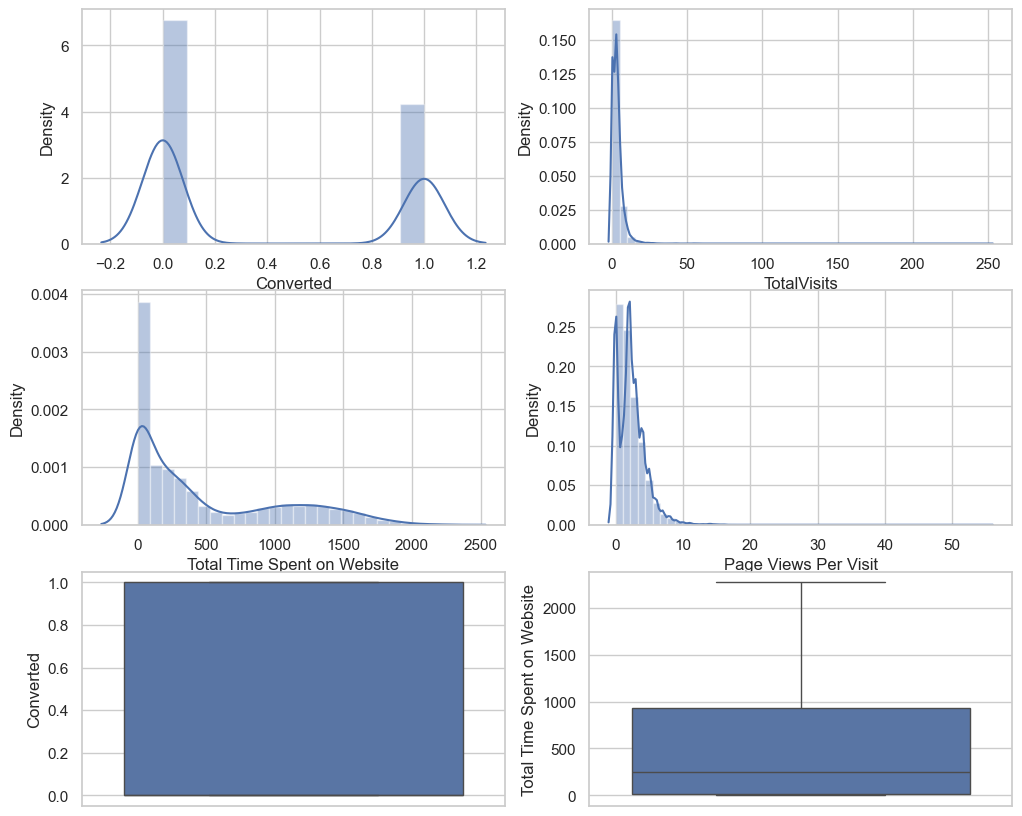

In [877]:
# Univariate analysis of all the numerical variables

plt.figure(figsize=(12,14))

# Let's explore distribution of each numberic variable
plt.subplot(4,2,1)
sns.distplot(df2.Converted)
plt.subplots_adjust(wspace=0.2)

plt.subplot(4,2,2)
sns.distplot(df2.TotalVisits)
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.2)

plt.subplot(4,2,3)
sns.distplot(df2["Total Time Spent on Website"])
plt.subplots_adjust(hspace=0.2)
                   
plt.subplot(4,2,4)
sns.distplot(df2["Page Views Per Visit"])
plt.subplots_adjust(wspace=0.2)

# Do we have outlier? Let's find out

plt.subplot(4,2,5)
sns.boxplot(df2.Converted)
plt.subplots_adjust(wspace=0.2)

plt.subplot(4,2,6)
sns.boxplot(df2["Total Time Spent on Website"])
plt.subplots_adjust(wspace=0.2)


plt.show()

In [878]:
obj_features = []
for col in df2.columns:
    if df2[col].dtype == "object":
        obj_features.append (col)
print(obj_features)

['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Last Activity', 'Country', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']


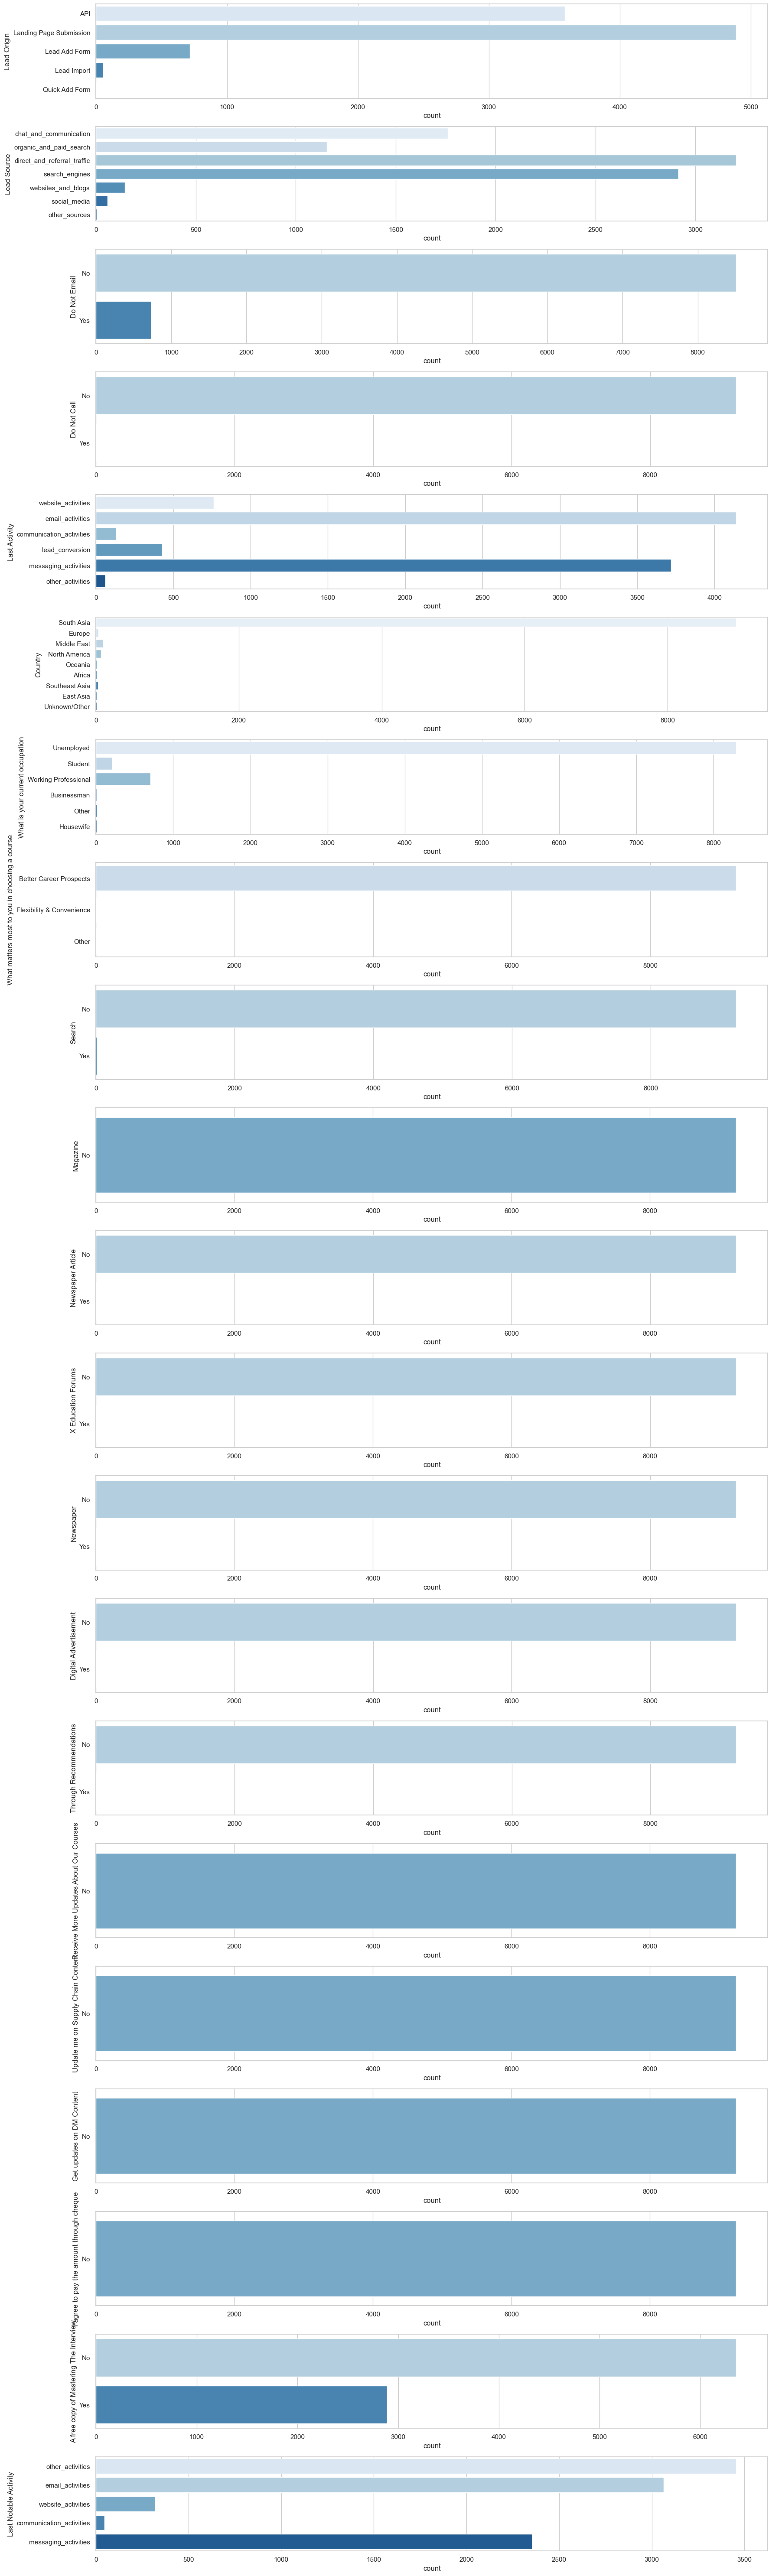

In [879]:
# Univariate analysis of all the categorical variables
plt.figure(figsize=(20,80))
for i, feature in enumerate(obj_features,1):
    ax = plt.subplot(22,1,i)
    sns.countplot(data=df2,y=feature,palette="Blues")
    x_label = ax.get_xlabel()
    y_label = ax.get_ylabel()
    #ax.set_ylabel(' ')
    #plt.title(f"{x_label} Vs {y_label}",fontsize=19,color="green")
    plt.subplots_adjust(hspace=0.3)

💡 We noticed that some features contain only a single value, such as **`NO`**. To enhance our dataset's quality, we will **remove** these features. Additionally, we identified features with **low variability**, like **`Do Not Call`**, **`Country`**, **`Newspaper Artice`**, **`X Education Forums`**, **`Newspaper`**, **`Digital Advertisement`**, **`Through Recommendations`** and **`Search`**. We plan to exclude these features during the feature selection process for model building. 

In [881]:
# Finding the features which have only No as values
Obj_features_value_as_no=[]
for col in df2[obj_features]:
    if "Yes" not in df2[col].values and "No" in df2[col].values:
        Obj_features_value_as_no.append(col)
print(Obj_features_value_as_no)

['Magazine', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque']


In [882]:
# Dropping features and verifying the columns after dropping in df1
df1.drop(Obj_features_value_as_no, axis=1, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 20 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Do Not Call                                    9240 non-null   object 
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9240 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9240 non-null   float64
 8   Last Activity                                  9240 non-null   object 
 9   Country                                        9240 

In [883]:
# Dropping features and verifying the columns after dropping in df2 (for visualisation only)
df2.drop(Obj_features_value_as_no, axis=1, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 20 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Do Not Call                                    9240 non-null   object 
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9240 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9240 non-null   float64
 8   Last Activity                                  9240 non-null   object 
 9   Country                                        9240 

##### <span style="color:Green"> 3.2 Bivariate analysis </span>

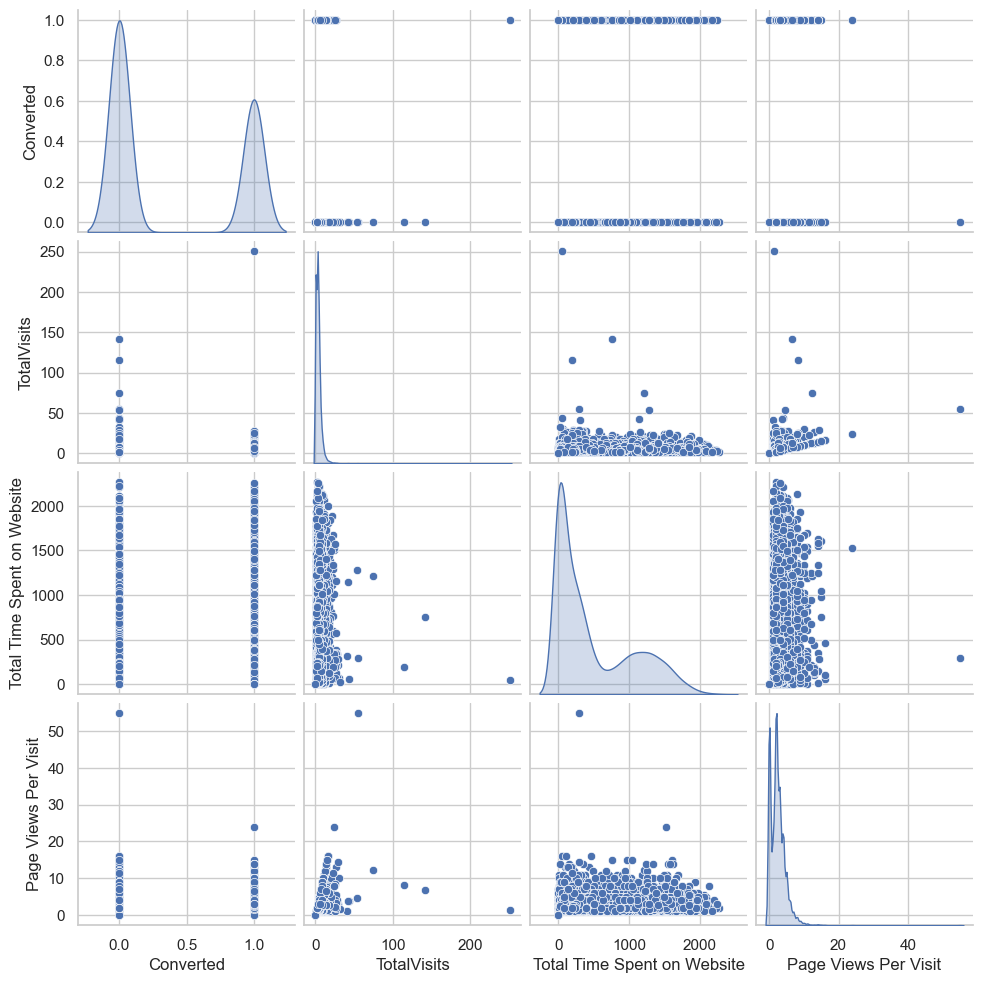

In [885]:
# Numeric variables
sns.pairplot(df2[int_features],diag_kind='kde')
plt.show()

💡 We found a linear relationship between **`TotalVisits`** and **`Page Views Per Visit`**. This linearity could be due to an inherent correlation between the two variables, which seems quite evident.


In [887]:
# Ensure obj_features contains valid column names
obj_features = [col for col in obj_features if col in df2.columns]

# Listing non-binary class features
non_binary_Obj_features = []
for col in obj_features:
    if "Yes" not in df2[col].values or "No" not in df2[col].values:
        non_binary_Obj_features.append(col)
print(non_binary_Obj_features)

['Lead Origin', 'Lead Source', 'Last Activity', 'Country', 'What is your current occupation', 'What matters most to you in choosing a course', 'Last Notable Activity']


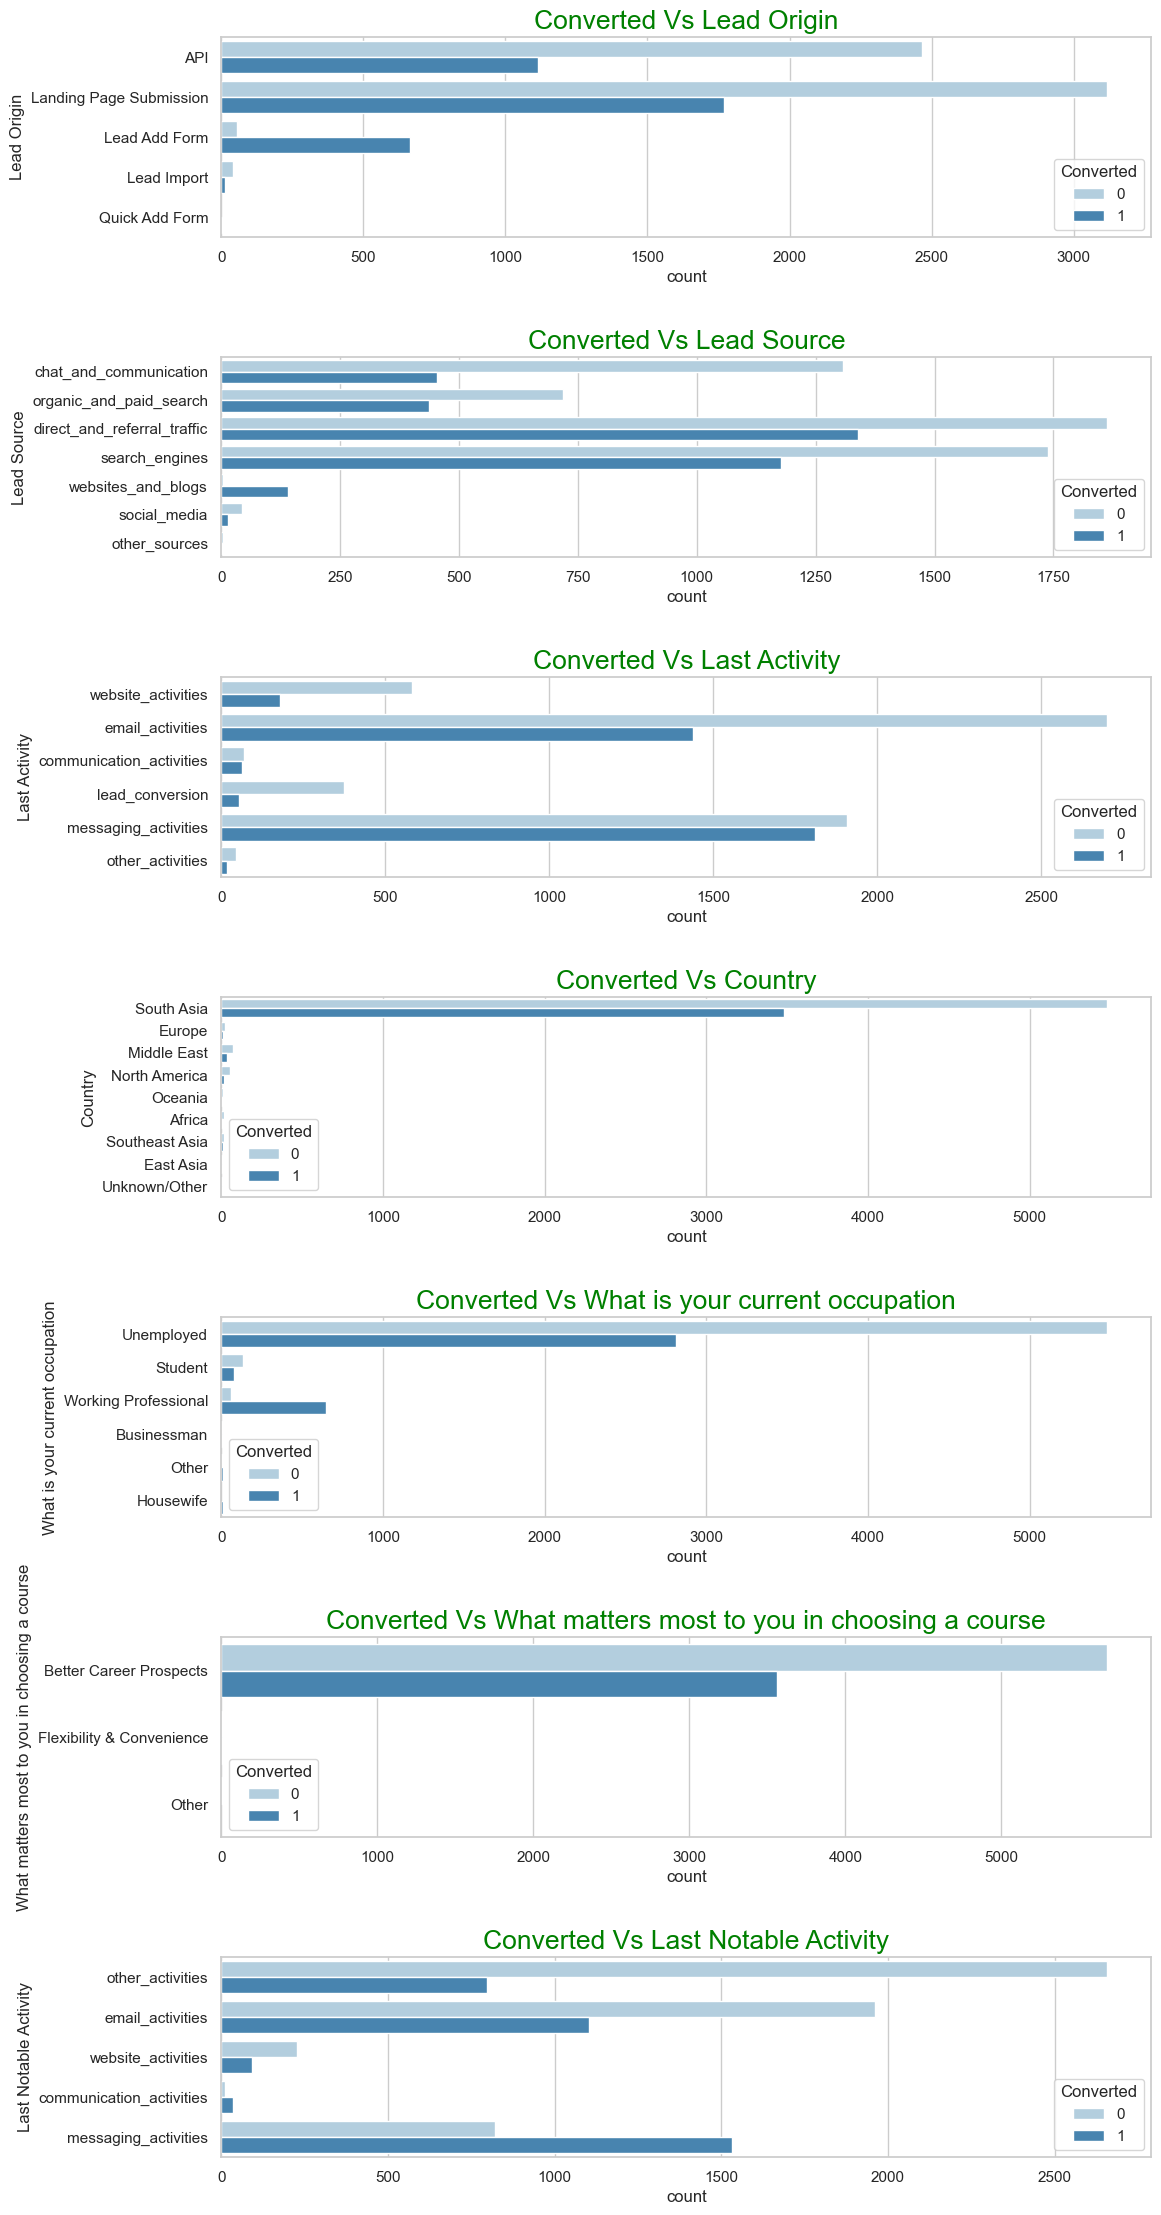

In [888]:
# Let's explore how customers became leads across each non-binary class object feature
plt.figure(figsize=(12,40))
for i, feature in enumerate(non_binary_Obj_features,1):
    ax = plt.subplot(10,1,i)
    sns.countplot(data=df2,y=feature,hue="Converted",palette="Blues")
    x_label = ax.get_xlabel()
    y_label = ax.get_ylabel()
    #ax.set_ylabel(' ')
    plt.title(f"Converted Vs {y_label}",fontsize=19,color="green")
    plt.subplots_adjust(hspace=0.6)

In [889]:
# Listing binary classes
binary_obj_features = [feature for feature in obj_features if feature not in non_binary_Obj_features]
print(binary_obj_features, end='')

['Do Not Email', 'Do Not Call', 'Search', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'A free copy of Mastering The Interview']

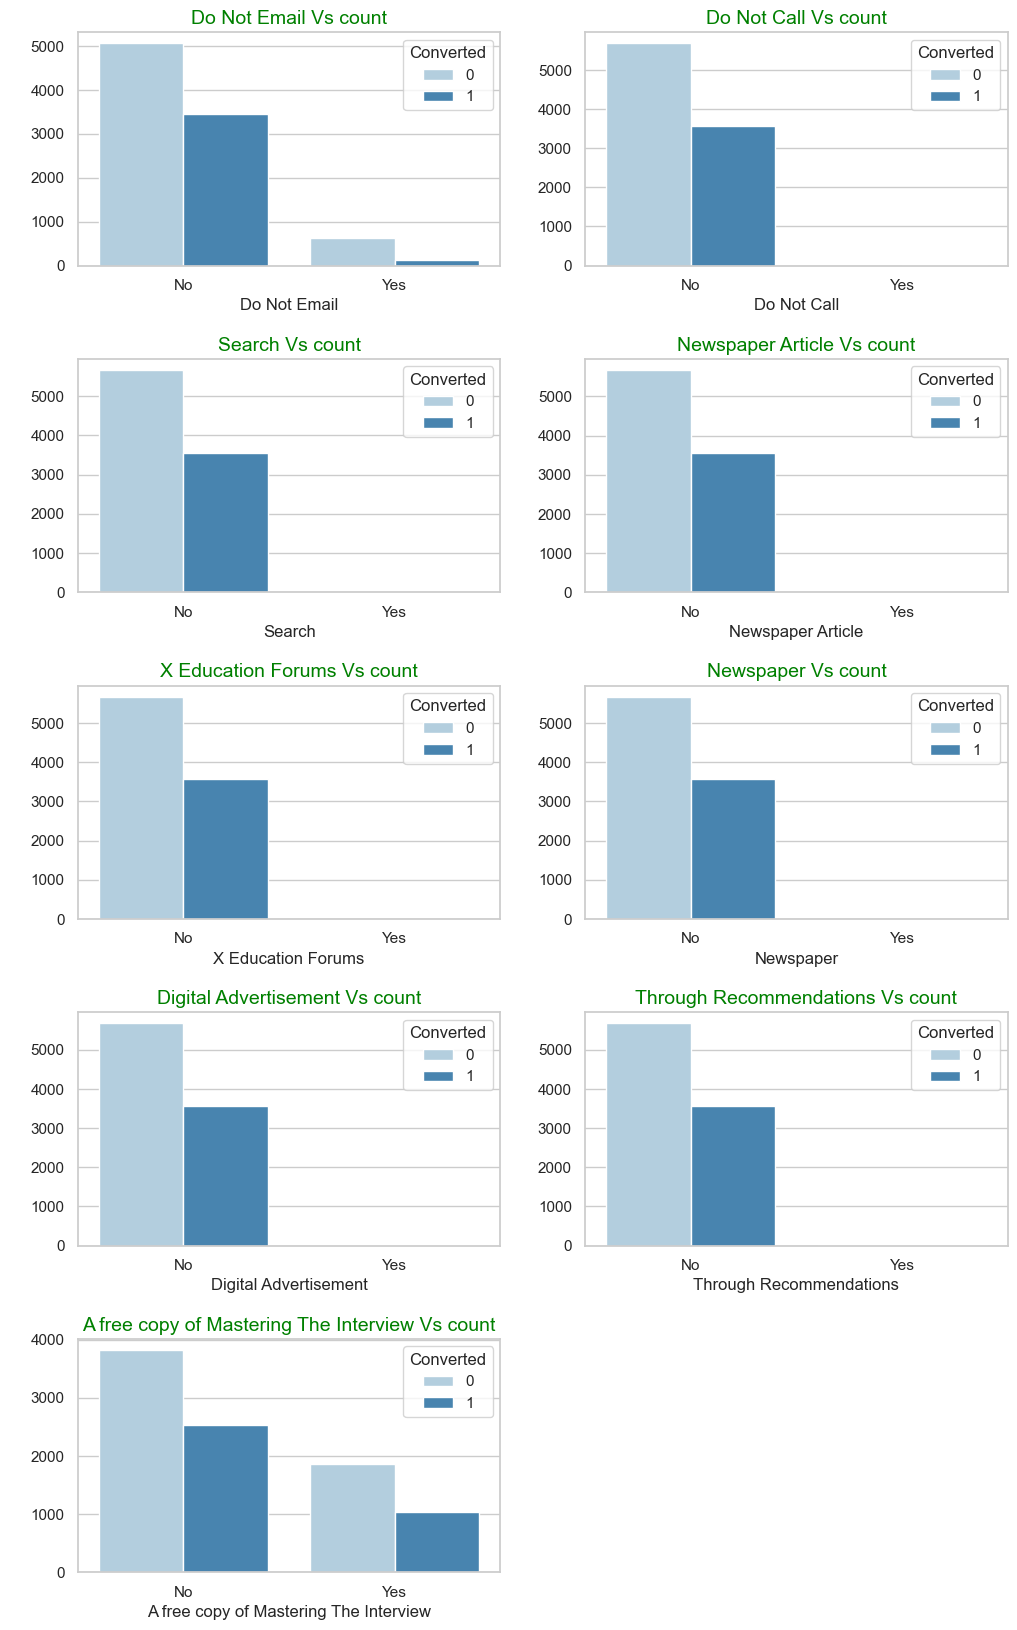

In [890]:
# Let's explore how customers became leads across each binary class object feature
plt.figure(figsize=(12,20))
for i, feature in enumerate(binary_obj_features,1):
    ax = plt.subplot(5,2,i)
    sns.countplot(data=df2,x=feature,hue="Converted",palette="Blues")
    x_label = ax.get_xlabel()
    y_label = ax.get_ylabel()
    ax.set_ylabel(' ')
    plt.title(f"{x_label} Vs {y_label}",fontsize=14,color="green")
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

##### <span style="color:Green"> 3.3 Multivariate analysis </span>

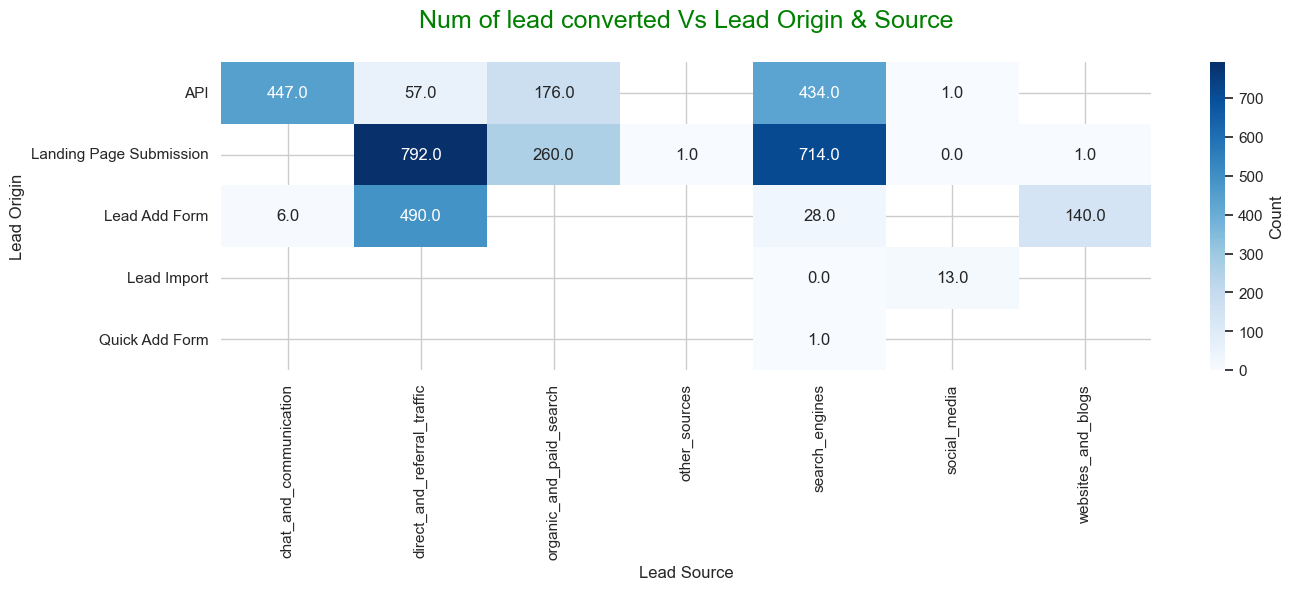

In [892]:
plt.figure(figsize=(15,4))
res=pd.pivot_table(data=df2, index="Lead Origin",columns="Lead Source",values="Converted",aggfunc=lambda x:x.sum())
sns.heatmap(res,cmap="Blues", annot=True,fmt='.1f',cbar_kws={"label":"Count"})
plt.title("Num of lead converted Vs Lead Origin & Source\n",color="Green", fontsize=18)
plt.show()

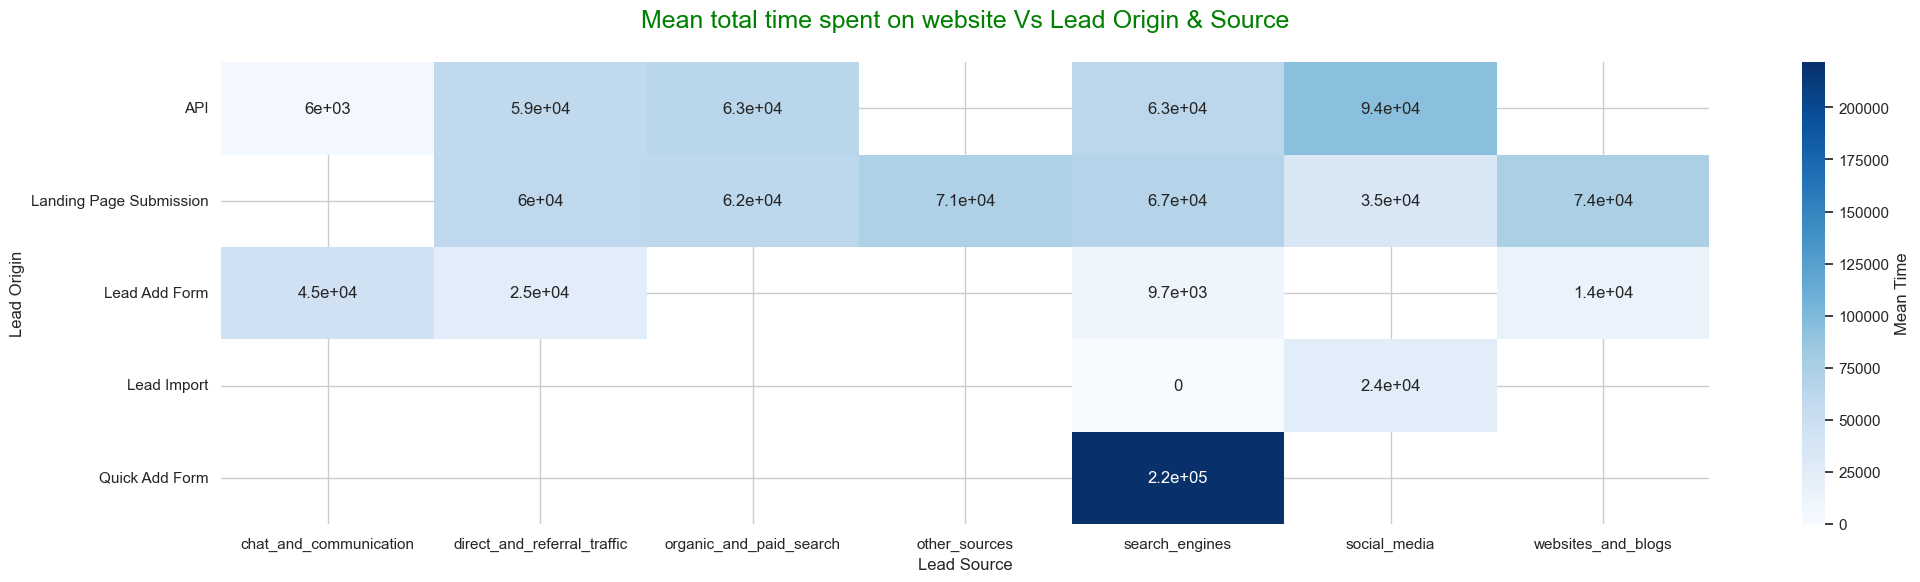

In [893]:
plt.figure(figsize=(24,6))
res=pd.pivot_table(data=df2, index="Lead Origin",columns="Lead Source",values="Total Time Spent on Website",aggfunc=lambda x:x.mean()*100)
sns.heatmap(res,cmap="Blues", annot=True,cbar_kws={"label":"Mean Time"})
plt.title("Mean total time spent on website Vs Lead Origin & Source\n",color="Green", fontsize=18)
plt.show()

💡 Place holder for Insights

##### <span style="color:Green"> 3.4 Outlier handling </span>

In [896]:
# Checking for outliers in the continuous variables
int_features

['Converted',
 'TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit']

In [897]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
df1[int_features].describe(percentiles=[0.25,0.5,0.75,0.90,0.95,0.99])

Converted  TotalVisits  Total Time Spent on Website  \
count  9240.000000  9240.000000                  9240.000000   
mean      0.385390     3.438636                   487.698268   
std       0.486714     4.819024                   548.021466   
min       0.000000     0.000000                     0.000000   
25%       0.000000     1.000000                    12.000000   
50%       0.000000     3.000000                   248.000000   
75%       1.000000     5.000000                   936.000000   
90%       1.000000     7.000000                  1380.000000   
95%       1.000000    10.000000                  1562.000000   
99%       1.000000    17.000000                  1840.610000   
max       1.000000   251.000000                  2272.000000   

       Page Views Per Visit  
count           9240.000000  
mean               2.357440  
std                2.145781  
min                0.000000  
25%                1.000000  
50%                2.000000  
75%                3.000000  
90%                5.000000  
95%                6.000000  
99%                9.000000  
max               55.000000

In [898]:
# Cap the values of TotalVisits at 17 which is 99 percentile
df1['TotalVisits'] = df1['TotalVisits'].apply(lambda x: 17 if x > 17 else x)

# Cap the values of Page Views Per Visit at 9 which is 99 percentile
df1['Page Views Per Visit'] = df1['Page Views Per Visit'].apply(lambda x: 9 if x > 9 else x)

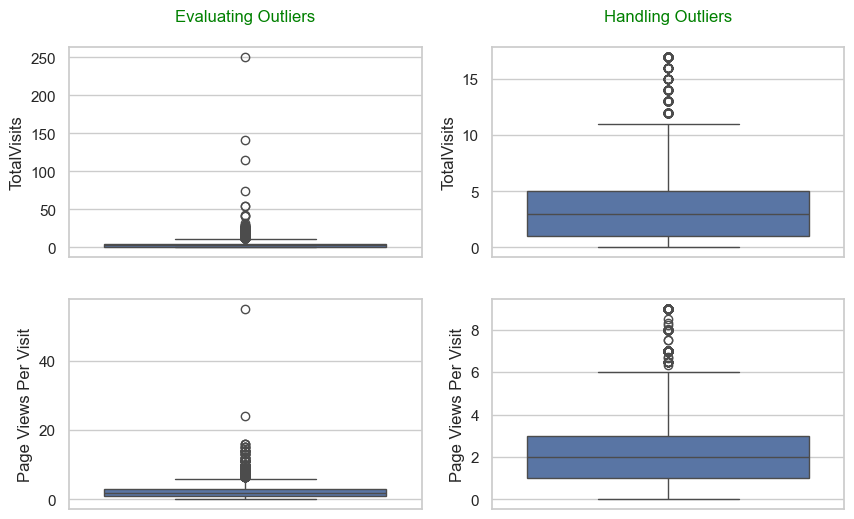

In [899]:
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
sns.boxplot(df2.TotalVisits)
plt.subplots_adjust(wspace=0.2)
plt.title("Evaluating Outliers\n", color="Green", fontsize=12)

plt.subplot(2,2,2)
sns.boxplot(df1['TotalVisits'])
plt.title("Handling Outliers\n", color="Green", fontsize=12)

plt.subplot(2,2,3)
sns.boxplot(df2["Page Views Per Visit"])
plt.subplots_adjust(wspace=0.2)


plt.subplot(2,2,4)
sns.boxplot(df1['Page Views Per Visit'])
plt.show()


In [900]:
df1[int_features].describe()

Converted  TotalVisits  Total Time Spent on Website  \
count  9240.000000  9240.000000                  9240.000000   
mean      0.385390     3.327814                   487.698268   
std       0.486714     3.228466                   548.021466   
min       0.000000     0.000000                     0.000000   
25%       0.000000     1.000000                    12.000000   
50%       0.000000     3.000000                   248.000000   
75%       1.000000     5.000000                   936.000000   
max       1.000000    17.000000                  2272.000000   

       Page Views Per Visit  
count           9240.000000  
mean               2.329050  
std                1.971347  
min                0.000000  
25%                1.000000  
50%                2.000000  
75%                3.000000  
max                9.000000

➡️  We adopted the **`Winsorizing`** technique to minimize the influence of outliers on statistical analysis of our data, ensuring our logistic regression model is more robust and less sensitive to anomalies.


### <span style="color:blue"> Model Biulding & Evaluation  </span>

#### 1. Data preparation for modelling

##### <span style="color:Green"> 1.1 Encoding </span>

In [905]:
df1[binary_obj_features].head()

Do Not Email Do Not Call Search Newspaper Article X Education Forums  \
0           No          No     No                No                 No   
1           No          No     No                No                 No   
2           No          No     No                No                 No   
3           No          No     No                No                 No   
4           No          No     No                No                 No   

  Newspaper Digital Advertisement Through Recommendations  \
0        No                    No                      No   
1        No                    No                      No   
2        No                    No                      No   
3        No                    No                      No   
4        No                    No                      No   

  A free copy of Mastering The Interview  
0                                     No  
1                                     No  
2                                    Yes  
3                                     No  
4                                     No

In [906]:
# Encode binary values, essential for logistic regression analysis
df1[binary_obj_features]=df1[binary_obj_features].apply(lambda x: x.map({"Yes":1,"No":0}))

In [907]:
df1[binary_obj_features].head()

Do Not Email  Do Not Call  Search  Newspaper Article  X Education Forums  \
0             0            0       0                  0                   0   
1             0            0       0                  0                   0   
2             0            0       0                  0                   0   
3             0            0       0                  0                   0   
4             0            0       0                  0                   0   

   Newspaper  Digital Advertisement  Through Recommendations  \
0          0                      0                        0   
1          0                      0                        0   
2          0                      0                        0   
3          0                      0                        0   
4          0                      0                        0   

   A free copy of Mastering The Interview  
0                                       0  
1                                       0  
2                                       1  
3                                       0  
4                                       0

* Lets assign numeric values for non-binary object feature

##### <span style="color:Green"> 1.2 One-hot encoding (dummy) </span>

In [910]:
df1.shape

(9240, 20)

In [911]:
df2= pd.get_dummies(df1, columns=non_binary_Obj_features, drop_first=True,dtype=int)
df2.head()

Do Not Email  Do Not Call  Converted  TotalVisits  \
0             0            0          0          0.0   
1             0            0          0          5.0   
2             0            0          1          2.0   
3             0            0          0          1.0   
4             0            0          1          2.0   

   Total Time Spent on Website  Page Views Per Visit  Search  \
0                            0                   0.0       0   
1                          674                   2.5       0   
2                         1532                   2.0       0   
3                          305                   1.0       0   
4                         1428                   1.0       0   

   Newspaper Article  X Education Forums  Newspaper  ...  \
0                  0                   0          0  ...   
1                  0                   0          0  ...   
2                  0                   0          0  ...   
3                  0                   0          0  ...   
4                  0                   0          0  ...   

   Last Notable Activity_Form Submitted on Website  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Last Notable Activity_Had a Phone Conversation  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Last Notable Activity_Modified  \
0                               1   
1                               0   
2                               0   
3                               1   
4                               1   

   Last Notable Activity_Olark Chat Conversation  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Last Notable Activity_Page Visited on Website  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Last Notable Activity_Resubscribed to emails  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   Last Notable Activity_SMS Sent  Last Notable Activity_Unreachable  \
0                               0                                  0   
1                               0                                  0   
2                               0                                  0   
3                               0                                  0   
4                               0                                  0   

   Last Notable Activity_Unsubscribed  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   Last Notable Activity_View in browser link Clicked  
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

[5 rows x 112 columns]

In [912]:
df2.shape

(9240, 112)

##### <span style="color:Green"> 1.3 Test-Train Split </span>

In [914]:
X=df2.drop("Converted", axis=1)
y=df2.Converted

In [915]:
np.random.seed(0)
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.7, random_state=100)

In [916]:
print("Train X shape:",X_train.shape)
print("Test X shape:",X_test.shape)
print("Train y shape:",y_train.shape)
print("Test y shape:",y_test.shape)

Train X shape: (6468, 111)
Test X shape: (2772, 111)
Train y shape: (6468,)
Test y shape: (2772,)


##### <span style="color:Green"> 1.4 Scaling </span>

In [918]:
scaler = MinMaxScaler()

In [919]:
#fitting and transforming the train data points
X_train_scaled=scaler.fit_transform(X_train)

# Transforming the test data points only
X_test_scaled=scaler.transform(X_test)

# Convert the NumPy array back to a pandas DataFrame
X_train_scaled= pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled= pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [920]:
X_train_scaled.head(2)

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
0           0.0          0.0     0.000000                     0.000000   
1           0.0          0.0     0.235294                     0.214349   

   Page Views Per Visit  Search  Newspaper Article  X Education Forums  \
0              0.000000     0.0                0.0                 0.0   
1              0.147778     0.0                0.0                 0.0   

   Newspaper  Digital Advertisement  ...  \
0        0.0                    0.0  ...   
1        0.0                    0.0  ...   

   Last Notable Activity_Form Submitted on Website  \
0                                              0.0   
1                                              0.0   

   Last Notable Activity_Had a Phone Conversation  \
0                                             0.0   
1                                             0.0   

   Last Notable Activity_Modified  \
0                             0.0   
1                             0.0   

   Last Notable Activity_Olark Chat Conversation  \
0                                            0.0   
1                                            0.0   

   Last Notable Activity_Page Visited on Website  \
0                                            0.0   
1                                            0.0   

   Last Notable Activity_Resubscribed to emails  \
0                                           0.0   
1                                           0.0   

   Last Notable Activity_SMS Sent  Last Notable Activity_Unreachable  \
0                             0.0                                0.0   
1                             0.0                                0.0   

   Last Notable Activity_Unsubscribed  \
0                                 0.0   
1                                 0.0   

   Last Notable Activity_View in browser link Clicked  
0                                                0.0   
1                                                0.0   

[2 rows x 111 columns]

In [921]:
X_test_scaled.head(2)

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
0           0.0          0.0     0.470588                     0.444982   
1           0.0          0.0     0.000000                     0.000000   

   Page Views Per Visit  Search  Newspaper Article  X Education Forums  \
0              0.888889     0.0                0.0                 0.0   
1              0.000000     0.0                0.0                 0.0   

   Newspaper  Digital Advertisement  ...  \
0        0.0                    0.0  ...   
1        0.0                    0.0  ...   

   Last Notable Activity_Form Submitted on Website  \
0                                              0.0   
1                                              0.0   

   Last Notable Activity_Had a Phone Conversation  \
0                                             0.0   
1                                             0.0   

   Last Notable Activity_Modified  \
0                             0.0   
1                             0.0   

   Last Notable Activity_Olark Chat Conversation  \
0                                            0.0   
1                                            0.0   

   Last Notable Activity_Page Visited on Website  \
0                                            0.0   
1                                            0.0   

   Last Notable Activity_Resubscribed to emails  \
0                                           0.0   
1                                           0.0   

   Last Notable Activity_SMS Sent  Last Notable Activity_Unreachable  \
0                             1.0                                0.0   
1                             1.0                                0.0   

   Last Notable Activity_Unsubscribed  \
0                                 0.0   
1                                 0.0   

   Last Notable Activity_View in browser link Clicked  
0                                                0.0   
1                                                0.0   

[2 rows x 111 columns]

##### <span style="color:Green"> 1.5 Evaluating Correlation </span>

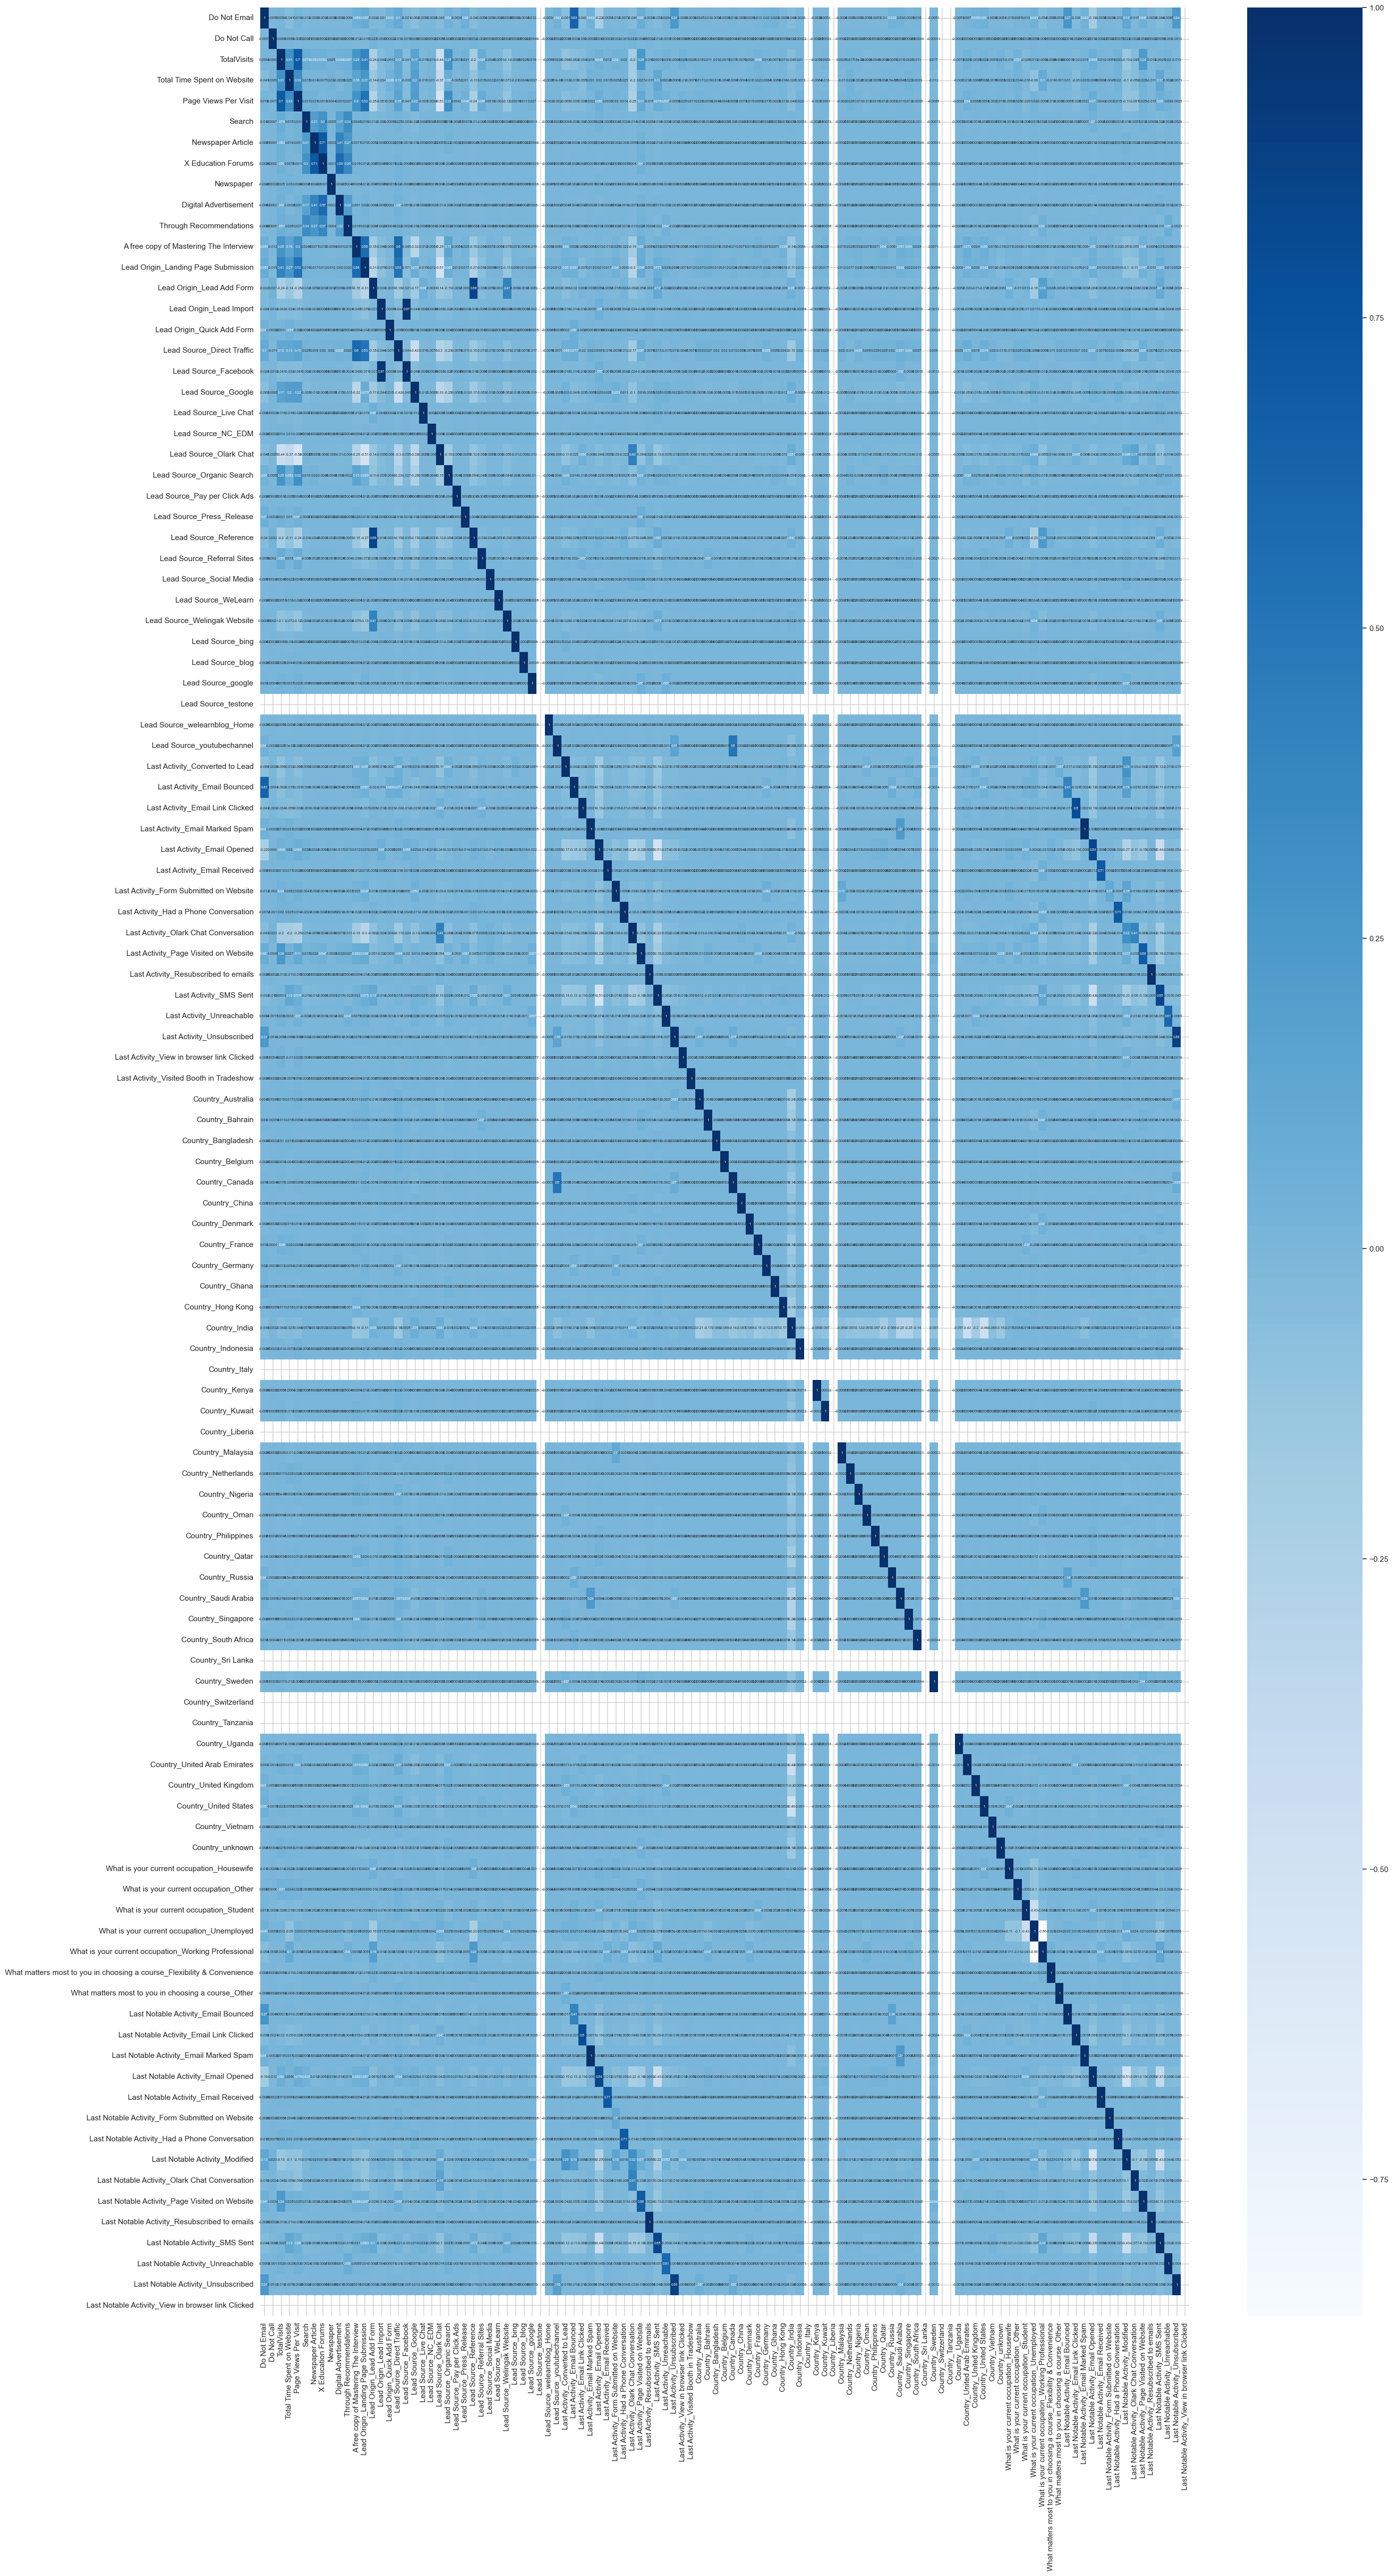

In [923]:
# Let's see the correlation matrix 
plt.figure(figsize = (30,60))        # Size of the figure
sns.heatmap(X_train_scaled.corr(),annot = True,cmap="Blues",annot_kws={"fontsize": 5})
plt.show()

##### <span style="color:Green"> 1.6 Feature Selection </span>

In [925]:
estimator=LogisticRegression()
selector=RFE(estimator,n_features_to_select=15)
selector.fit(X_train_scaled,y_train)

# let see the ranking of each feature
list(zip(X_train.columns,selector.support_,selector.ranking_))

[('Do Not Email', True, 1),
 ('Do Not Call', False, 22),
 ('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', True, 1),
 ('Search', False, 55),
 ('Newspaper Article', False, 42),
 ('X Education Forums', False, 54),
 ('Newspaper', False, 18),
 ('Digital Advertisement', False, 15),
 ('Through Recommendations', False, 53),
 ('A free copy of Mastering The Interview', False, 88),
 ('Lead Origin_Landing Page Submission', False, 56),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 62),
 ('Lead Origin_Quick Add Form', False, 31),
 ('Lead Source_Direct Traffic', False, 30),
 ('Lead Source_Facebook', False, 38),
 ('Lead Source_Google', False, 41),
 ('Lead Source_Live Chat', False, 71),
 ('Lead Source_NC_EDM', False, 48),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 40),
 ('Lead Source_Pay per Click Ads', False, 67),
 ('Lead Source_Press_Release', False, 63),
 ('Lead Source_Reference', False, 7

In [926]:
# Top 15 features
features_to_keep = X_train.columns[selector.support_]
features_to_keep

Index(['Do Not Email', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Lead Origin_Lead Add Form',
       'Lead Source_Olark Chat', 'Lead Source_Welingak Website',
       'Last Activity_Had a Phone Conversation',
       'Last Activity_Olark Chat Conversation', 'Last Activity_SMS Sent',
       'Country_Qatar', 'What is your current occupation_Housewife',
       'What is your current occupation_Working Professional',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Unreachable'],
      dtype='object')

#### 2. Model building

In [928]:
# Adding constant
X_train_sm = sm.add_constant(X_train[features_to_keep])
X_test_sm = sm.add_constant(X_test[features_to_keep])

##### <span style="color:Green"> 2.1 Model-1</span>

In [930]:
# Evaluating each feature for its significance using StatsModels
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm1.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2739.0
Date:                Mon, 17 Feb 2025   Deviance:                       5478.1
Time:                        09:42:21   Pearson chi2:                 7.54e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.3827
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [931]:
# Dropping one of the most insignificant feature
X_train_sm=X_train_sm.drop(["Country_Qatar"],axis=1)
X_test_sm=X_test_sm.drop(["Country_Qatar"],axis=1)

##### <span style="color:Green"> 2.1 Model-2</span>

In [933]:
# Evaluating each feature for its significance using StatsModels
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res2 = logm2.fit()
print(res2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6453
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2742.4
Date:                Mon, 17 Feb 2025   Deviance:                       5484.7
Time:                        09:42:21   Pearson chi2:                 7.55e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3821
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [934]:
# Dropping one of the most insignificant feature
X_train_sm=X_train_sm.drop(["What is your current occupation_Housewife"],axis=1)
X_test_sm=X_test_sm.drop(["What is your current occupation_Housewife"],axis=1)

##### <span style="color:Green"> 2.1 Model-3</span>

In [936]:
# Evaluating each feature for its significance using StatsModels
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res3 = logm3.fit()
print(res3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2750.2
Date:                Mon, 17 Feb 2025   Deviance:                       5500.4
Time:                        09:42:22   Pearson chi2:                 7.58e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3806
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [937]:
# Dropping one of the most insignificant feature
X_train_sm=X_train_sm.drop(["Last Activity_Had a Phone Conversation"],axis=1)
X_test_sm=X_test_sm.drop(["Last Activity_Had a Phone Conversation"],axis=1)

##### <span style="color:Green"> 2.1 Model-4</span>

In [939]:
# Evaluating each feature for its significance using StatsModels
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res4 = logm4.fit()
print(res4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6455
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2750.4
Date:                Mon, 17 Feb 2025   Deviance:                       5500.8
Time:                        09:42:22   Pearson chi2:                 7.38e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3805
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

##### <span style="color:Green"> 2.2 Evaluating Multicolinarity</span>

In [941]:
vif=pd.DataFrame()
vif["Feature"]=X_train_sm.columns

vif["VIF"]=[variance_inflation_factor(X_train_sm.values,i) 
                 for i in range(len(X_train_sm.columns))]
print(vif)

                                              Feature       VIF
0                                               const  7.591434
1                                        Do Not Email  1.013578
2                                         TotalVisits  2.014263
3                         Total Time Spent on Website  1.262414
4                                Page Views Per Visit  2.447771
5                           Lead Origin_Lead Add Form  1.563826
6                              Lead Source_Olark Chat  1.949060
7                        Lead Source_Welingak Website  1.219816
8               Last Activity_Olark Chat Conversation  1.278926
9                              Last Activity_SMS Sent  1.094128
10  What is your current occupation_Working Profes...  1.086627
11     Last Notable Activity_Had a Phone Conversation  1.002870
12                  Last Notable Activity_Unreachable  1.003282


➡️ The features of model-4 exhibit moderate correlation, as their VIF values lie between 1 and 5.


##### <span style="color:Green"> 2.3 Evaluating model result</span>

In [944]:
# Finding predicted values for each feture on the train set i.e probability of getting 1
y_train_pred = res4.predict(X_train_sm).values.reshape(-1)
y_train_pred[:10]

array([0.2172537 , 0.20361106, 0.29171523, 0.76474393, 0.2172537 ,
       0.99154949, 0.10718289, 0.99158807, 0.28060356, 0.88289789])

In [945]:
# Creating a dataframe with the actual converted and the predicted probabilities
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Probability':y_train_pred})
y_train_pred_final.head()

Converted  Converted_Probability
0          0               0.217254
1          0               0.203611
2          0               0.291715
3          0               0.764744
4          0               0.217254

In [946]:
# Creating new column 'predicted' with 1 if Converted_Probability > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Probability.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head(-1)

Converted  Converted_Probability  predicted
0             0               0.217254          0
1             0               0.203611          0
2             0               0.291715          0
3             0               0.764744          1
4             0               0.217254          0
...         ...                    ...        ...
6462          1               0.769115          1
6463          1               0.769115          1
6464          1               0.995900          1
6465          1               0.217254          0
6466          0               0.108955          0

[6467 rows x 3 columns]

##### Matrix Evaluation-1  - with cut-off: 0.5

In [948]:
# creating the confusion matrix
cm = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(cm)

[[3520  482]
 [ 742 1724]]


In [949]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.8107606679035251


In [950]:
# Extracting the components of the confusion matrix
TP = cm[1,1] # True Positives (correctly predicted positive cases)
TN = cm[0,0] # True Negatives (correctly predicted negative cases)
FP = cm[0,1] # False Positives (incorrectly predicted positive cases)
FN = cm[1,0] # False Negatives (incorrectly predicted negative cases)

In [951]:
# Finding Sensitivity or True Positive rate or Recall
recall =round(TP/(TP+FN),2)
recall

0.7

In [952]:
# Finding Specificity
specificity=round(TN/(TN+FP),2)
specificity

0.88

In [953]:
# Negative predictive value
round(TN/(TN+FN),2)

0.83

In [954]:
# Precision or Positive predictive value 
precision=round(TP/(TP+FP),2)
precision

0.78

In [955]:
# F1-Score 
round(2*precision*recall/(precision+recall),2)

0.74

In [956]:
# plotting a ROC Curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

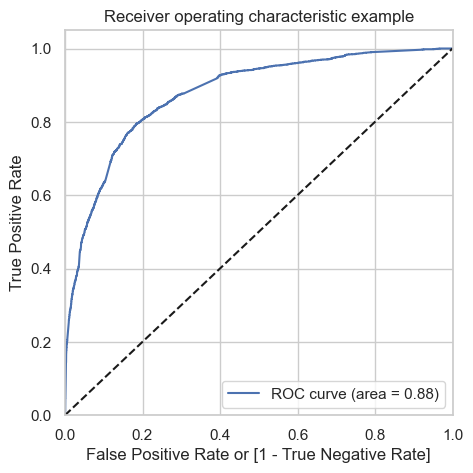

In [957]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_Probability, drop_intermediate = False )
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Probability)

💡 The **ROC curve** illustrates the relationship between the **true positive rate** and the **false positive rate**. Our model's path, which follows the **left-hand border** and then the **top border** of the ROC space, indicates that the model possesses high **discriminatory power** with an **AUC** of **0.88**.Thus making it more **`accurate`**


In [959]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Probability.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted  Converted_Probability  predicted  0.0  0.1  0.2  0.3  0.4  0.5  \
0          0               0.217254          0    1    1    1    0    0    0   
1          0               0.203611          0    1    1    1    0    0    0   
2          0               0.291715          0    1    1    1    0    0    0   
3          0               0.764744          1    1    1    1    1    1    1   
4          0               0.217254          0    1    1    1    0    0    0   

   0.6  0.7  0.8  0.9  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    1    1    0    0  
4    0    0    0    0

In [960]:
# Assessing the model's performance across different cutoff values by calculating key accuracy, sensitivity and specificity

import pandas as pd
from sklearn import metrics

# Initialize DataFrame to store results
cutoff_df = pd.DataFrame(columns=['prob', 'accuracy', 'sensi', 'speci'])

# Define the probability cutoffs
num = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in num:
    # Create binary predictions based on the cutoff value
    y_train_pred_final['predicted'] = y_train_pred_final['Converted_Probability'] >= i
    
    # Calculate the confusion matrix
    cm1 = metrics.confusion_matrix(y_train_pred_final['Converted'], y_train_pred_final['predicted'])
    
    # Calculate total number of observations
    total1 = sum(sum(cm1))
    
    # Calculate accuracy
    accuracy = (cm1[0,0] + cm1[1,1]) / total1
    
    # Calculate specificity
    speci = cm1[0,0] / (cm1[0,0] + cm1[0,1])
    
    # Calculate sensitivity
    sensi = cm1[1,1] / (cm1[1,0] + cm1[1,1])
    
    # Store the results in the DataFrame
    cutoff_df.loc[i] = [i, accuracy, sensi, speci]

print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.381262  1.000000  0.000000
0.1   0.1  0.594465  0.965126  0.366067
0.2   0.2  0.724954  0.926602  0.600700
0.3   0.3  0.793599  0.826034  0.773613
0.4   0.4  0.811688  0.762368  0.842079
0.5   0.5  0.810761  0.699108  0.879560
0.6   0.6  0.792053  0.582320  0.921289
0.7   0.7  0.779530  0.506894  0.947526
0.8   0.8  0.745516  0.381184  0.970015
0.9   0.9  0.714595  0.269667  0.988756


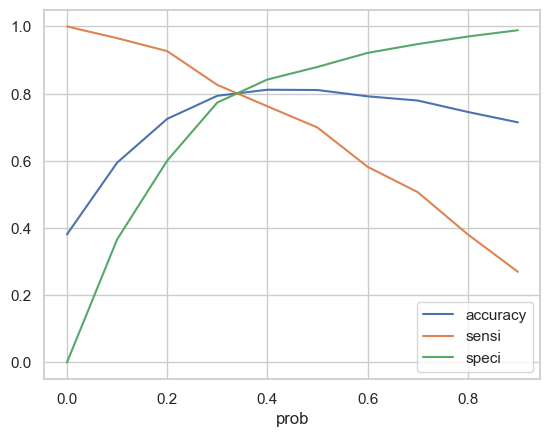

In [961]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

💡 **`0.3`** seems to be optimal cut-off probability

In [963]:
# Changing the cut-off from 0.5 to 0.3
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Probability.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

Converted  Converted_Probability  predicted  0.0  0.1  0.2  0.3  0.4  0.5  \
0          0               0.217254      False    1    1    1    0    0    0   
1          0               0.203611      False    1    1    1    0    0    0   
2          0               0.291715      False    1    1    1    0    0    0   
3          0               0.764744      False    1    1    1    1    1    1   
4          0               0.217254      False    1    1    1    0    0    0   

   0.6  0.7  0.8  0.9  final_predicted  
0    0    0    0    0                0  
1    0    0    0    0                0  
2    0    0    0    0                0  
3    1    1    0    0                1  
4    0    0    0    0                0

##### Matrix Evaluation-2    with cut-off: 0.3

In [965]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7935992578849722

In [966]:
# creating the confusion matrix
cm2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
print(cm2)

[[3096  906]
 [ 429 2037]]


In [967]:
# Extracting the components of the confusion matrix
TP = cm2[1,1] # True Positives (correctly predicted positive cases)
TN = cm2[0,0] # True Negatives (correctly predicted negative cases)
FP = cm2[0,1] # False Positives (incorrectly predicted positive cases)
FN = cm2[1,0] # False Negatives (incorrectly predicted negative cases)

In [968]:
# Finding Sensitivity or True Positive rate or Recall
recall2 =round(TP/(TP+FN),2)
recall2

0.83

In [969]:
# Precision or Positive predictive value 
precision2=round(TP/(TP+FP),2)
precision2

0.69

In [970]:
# F1-Score 
round(2*precision2*recall2/(precision2+recall2),2)

0.75

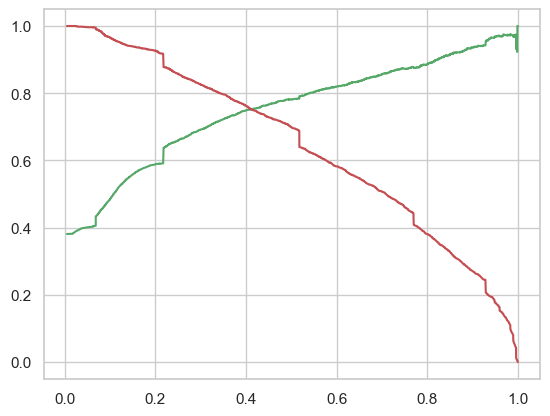

In [971]:
# Precision and recall tradeoff
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Probability)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [972]:
# Assigning Lead score to each training set data point
y_train_pred_final["Lead Score"]= y_train_pred_final["Converted_Probability"]*100
y_train_pred_final.head()

Converted  Converted_Probability  predicted  0.0  0.1  0.2  0.3  0.4  0.5  \
0          0               0.217254      False    1    1    1    0    0    0   
1          0               0.203611      False    1    1    1    0    0    0   
2          0               0.291715      False    1    1    1    0    0    0   
3          0               0.764744      False    1    1    1    1    1    1   
4          0               0.217254      False    1    1    1    0    0    0   

   0.6  0.7  0.8  0.9  final_predicted  Lead Score  
0    0    0    0    0                0   21.725370  
1    0    0    0    0                0   20.361106  
2    0    0    0    0                0   29.171523  
3    1    1    0    0                1   76.474393  
4    0    0    0    0                0   21.725370

##### <span style="color:Green"> 2.4 Making prediction on test data</span>

In [974]:
X_test_scaled.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
0           0.0          0.0     0.470588                     0.444982   
1           0.0          0.0     0.000000                     0.000000   
2           0.0          0.0     0.294118                     0.025968   
3           0.0          0.0     0.000000                     0.000000   
4           0.0          0.0     0.000000                     0.000000   

   Page Views Per Visit  Search  Newspaper Article  X Education Forums  \
0              0.888889     0.0                0.0                 0.0   
1              0.000000     0.0                0.0                 0.0   
2              0.555556     0.0                0.0                 0.0   
3              0.000000     0.0                0.0                 0.0   
4              0.000000     0.0                0.0                 0.0   

   Newspaper  Digital Advertisement  ...  \
0        0.0                    0.0  ...   
1        0.0                    0.0  ...   
2        0.0                    0.0  ...   
3        0.0                    0.0  ...   
4        0.0                    0.0  ...   

   Last Notable Activity_Form Submitted on Website  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   Last Notable Activity_Had a Phone Conversation  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   Last Notable Activity_Modified  \
0                             0.0   
1                             0.0   
2                             0.0   
3                             1.0   
4                             0.0   

   Last Notable Activity_Olark Chat Conversation  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   Last Notable Activity_Page Visited on Website  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   Last Notable Activity_Resubscribed to emails  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   Last Notable Activity_SMS Sent  Last Notable Activity_Unreachable  \
0                             1.0                                0.0   
1                             1.0                                0.0   
2                             0.0                                1.0   
3                             0.0                                0.0   
4                             0.0                                0.0   

   Last Notable Activity_Unsubscribed  \
0                                 0.0   
1                                 0.0   
2                                 0.0   
3                                 0.0   
4                                 0.0   

   Last Notable Activity_View in browser link Clicked  
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

[5 rows x 111 columns]

In [975]:
# predicting probability on test data
y_test_pred = res4.predict(X_test_sm)

In [976]:
y_test_pred[:10]

4269    0.668683
2376    0.927897
7766    0.901022
9199    0.068646
4359    0.769115
9186    0.484365
1631    0.353503
8963    0.129696
8007    0.129568
5324    0.285211
dtype: float64

In [977]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_test_pred)
# Renaming the column 
y_pred_df= y_pred_df.rename(columns={ 0 : 'Converted_Prob'})
y_pred_df.head()

Converted_Prob
4269        0.668683
2376        0.927897
7766        0.901022
9199        0.068646
4359        0.769115

In [978]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [979]:
# Appending y_test_df and y_pred_df
y_pred_final = pd.concat([y_test_df, y_pred_df],axis=1)
y_pred_final.head()

Converted  Converted_Prob
4269          1        0.668683
2376          1        0.927897
7766          1        0.901022
9199          0        0.068646
4359          1        0.769115

In [980]:
# Asigning the optimal cut-off values (which we obtained earlier) on probability to make final prediction 
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.3 else 0)
y_pred_final.head()

Converted  Converted_Prob  final_predicted
4269          1        0.668683                1
2376          1        0.927897                1
7766          1        0.901022                1
9199          0        0.068646                0
4359          1        0.769115                1

In [981]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.7994227994227994

In [982]:
# creating the confusion matrix
cm3 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
cm3

array([[1308,  369],
       [ 187,  908]], dtype=int64)

In [983]:
# Extracting the components of the confusion matrix
TP = cm3[1,1] # True Positives (correctly predicted positive cases)
TN = cm3[0,0] # True Negatives (correctly predicted negative cases)
FP = cm3[0,1] # False Positives (incorrectly predicted positive cases)
FN = cm3[1,0] # False Negatives (incorrectly predicted negative cases)

In [984]:
# Finding Sensitivity or True Positive rate or Recall
recall_t =round(TP/(TP+FN),2)
recall_t

0.83

In [985]:
# Precision or Positive predictive value 
precision_t=round(TP/(TP+FP),2)
precision_t

0.71

In [986]:
# F1-Score 
round(2*precision_t*recall_t/(precision_t+recall_t),2)

0.77

In [987]:
# Assigning Lead score to each training set data point
y_pred_final["Lead Score"]= y_pred_final["Converted_Prob"]*100
y_pred_final.head()

Converted  Converted_Prob  final_predicted  Lead Score
4269          1        0.668683                1   66.868317
2376          1        0.927897                1   92.789725
7766          1        0.901022                1   90.102198
9199          0        0.068646                0    6.864602
4359          1        0.769115                1   76.911516